In [ ]:
import pandas as pd
import numpy as np

import gc
import pyarrow.parquet as pq

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from shaphypetune import BoostRFE
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Описание задачи

https://www.kaggle.com/competitions/amex-default-prediction/overview

American Express — глобальная интегрированная платежная компания. Являясь крупнейшим эмитентом платежных карт в мире, они предоставляют клиентам доступ к продуктам, информации и опыту, которые обогащают жизнь и способствуют успеху в бизнесе.

Целью этой задачи является прогнозирование вероятности того, что клиент не выплатит сумму остатка по кредитной карте в будущем, на основе его ежемесячного профиля клиента. 

Набор данных содержит агрегированные характеристики профиля для каждого клиента на каждую дату выписки. Функции анонимизированы и нормализованы и делятся на следующие общие категории:

- D_* = переменные просроченной задолженности
- S_* = Расходные переменные
- P_* = Платежные переменные
- B_* = Балансовые переменные
- R_* = Переменные риска

Следующие признаки, являются категоричными:

['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

Задача состоит в том, чтобы предсказать для каждого customer_ID вероятность невыполнения платежа в будущем (target = 1).

## EDA

In [ ]:
train_data = pd.read_parquet('train_data.parquet')

In [ ]:
train_data.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,-4532153018459703766,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,NaN,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674
1,-4532153018459703766,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,NaN,NaN,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217
2,-4532153018459703766,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,NaN,NaN,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603
3,-4532153018459703766,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,...,NaN,NaN,NaN,0.006117,0.004516,0.003200,NaN,0.008419,0.006527,0.009600
4,-4532153018459703766,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,...,NaN,NaN,NaN,0.003671,0.004946,0.008889,NaN,0.001670,0.008126,0.009827


С первого взгляда видим, что
- в наборе есть пропущенные значения;

In [ ]:
print(f'train_data_shape = {train_data.shape}')

train_data_shape = (5531451, 190)


In [ ]:
print(
    f'Количество уникальных клиентов = {len(pd.unique(train_data.customer_ID))}')

Количество уникальных клиентов = 458913


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 190 entries, customer_ID to D_145
dtypes: category(2), datetime64[ns](1), float32(176), float64(9), int64(2)
memory usage: 4.1 GB


In [ ]:
train_data.isna().sum().sort_values(ascending=False).head(10)

D_87     5527586
D_88     5525447
D_108    5502513
D_111    5500117
D_110    5500117
B_39     5497819
D_73     5475595
B_42     5459973
D_134    5336752
D_135    5336752
dtype: int64

Есть признаки со значительном количеством пропущенных значений. От таких признаков стоит избавиться.

In [ ]:
train_data.dropna(thresh=int(0.5*len(train_data)), axis=1, inplace=True)

In [ ]:
train_data.shape

(5531451, 160)

In [ ]:
cat_feat = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117',
            'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [ ]:
cat_feat = list(set(cat_feat) & set(train_data.columns))

In [ ]:
for f in cat_feat:
    display(train_data[f].value_counts())

0.0    4710663
1.0     763955
2.0      54817
Name: B_30, dtype: int64

1.0    3316478
0.0    2038257
Name: D_114, dtype: int64

O     2913244
U     1523448
R      840112
-1      37205
Name: D_64, dtype: int64

2.0    1953232
3.0    1255315
1.0    1160047
5.0     444856
4.0     294917
7.0     259028
6.0     162040
Name: B_38, dtype: int64

-1.0    1456084
 3.0    1166400
 4.0    1138666
 2.0     666808
 5.0     459290
 6.0     344520
 1.0     122967
Name: D_117, dtype: int64

0.0    4729723
1.0     625012
Name: D_120, dtype: int64

6.0    2782455
5.0    1201706
3.0     484442
4.0     477187
2.0     220111
1.0     133122
0.0      15925
Name: D_68, dtype: int64

0.0    5348109
1.0       6626
Name: D_116, dtype: int64

CO    4119621
CR     930133
CL     438390
XZ      25786
XM      10556
XL       6965
Name: D_63, dtype: int64

 1.0    4262414
 0.0     891323
-1.0     260898
Name: D_126, dtype: int64

D_63, D_64 нужно будет в дальнейшем бинаризовать, если будем использовать модели, не поддерживающие категориальные данные

Так как признаков много, рассмотрим каждый тип признаков отдельно

In [ ]:
delinquency_features = [i for i in train_data.columns if i.startswith('D_')]
spend_features = [i for i in train_data.columns if i.startswith('S_')]
payment_features = [i for i in train_data.columns if i.startswith('P_')]
balance_features = [i for i in train_data.columns if i.startswith('B_')]
risk_features = [i for i in train_data.columns if i.startswith('R_')]

In [ ]:
values = [len(delinquency_features), len(spend_features), len(payment_features),
          len(balance_features), len(risk_features)]
labels = ['delinquency', 'spend', 'payment', 'balance', 'risk']

Text(0.5, 1.0, 'Variables')

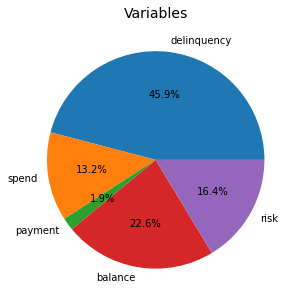

In [ ]:
fig = plt.figure(figsize=(5, 5))
plt.pie(values, labels=labels, autopct="%.1f%%")
plt.title("Variables", fontsize=14)

In [ ]:
def eda_features(dataset: pd.DataFrame, features: list) -> None:
    """
    Разведочный анализ группы признаков.
    Тепловая карта. Удаление сильно коррелирующих >0.95.
    Основные статистики.
    :param dataset - набор данных
    :param feautures - признака для исследования
    :return - None
    """

    data = dataset[features]
    display(data.head())

    # проверка на сильно коррелирующие признаки (> 0.95) и удаление, если таковые имеются
    corr = data.sample(100000).corr(method='pearson')

    fig = plt.figure(figsize=(len(features)/2, len(features)/2))
    sns.heatmap(corr, annot=True, fmt='.2f',
                mask=(np.abs(np.tril(corr)) <= 0.95))
    plt.show()

    upper_tri = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    for i in range(upper_tri.shape[0]):
        for c in range(upper_tri.shape[0]):
            if i != c:
                if np.abs(upper_tri.iloc[i, c]) > 0.95:
                    print(
                        f'{upper_tri.index[i]} имеет корреляцию с {upper_tri.columns[c]} = {upper_tri.iloc[i,c]}')

    to_drop = [column for column in upper_tri.columns if any(
        upper_tri[column] > 0.95)]
    if to_drop:
        for el in to_drop:
            features.remove(el)
        dataset.drop(columns=to_drop, inplace=True)

    display(data.drop(columns=to_drop).describe().T.style
            .bar(subset=["max"], color='red')
            .bar(subset=["mean", ], color='blue'))
    del corr
    del upper_tri
    del to_drop
    del data
    gc.collect()

### Delinquency_features

Признаки, характеризующие правонарушения

,D_39,D_41,D_43,D_44,D_45,D_46,D_47,D_48,D_51,D_52,...,D_129,D_130,D_131,D_133,D_139,D_140,D_141,D_143,D_144,D_145
0,0.001733,0.008771,NaN,0.000630,0.708906,0.358587,0.525351,0.255736,1.335856,0.207334,...,1.000080,0.002052,0.005972,0.004345,0.002427,0.003706,0.003818,0.000569,0.000610,0.002674
1,0.005775,0.000798,NaN,0.002526,0.712795,0.353630,0.521311,0.223329,1.339794,0.202778,...,1.008344,0.001034,0.004838,0.007495,0.003954,0.003167,0.005032,0.009576,0.005492,0.009217
2,0.091505,0.007598,NaN,0.007605,0.720884,0.334650,0.524568,0.189424,1.337179,0.206629,...,1.006878,0.005681,0.005497,0.009227,0.003269,0.007329,0.000427,0.003429,0.006986,0.002603
3,0.002455,0.000685,NaN,0.006406,0.723997,0.323271,0.530929,0.135586,1.339909,0.208214,...,1.007573,0.007108,0.008261,0.007206,0.006117,0.004516,0.003200,0.008419,0.006527,0.009600
4,0.002483,0.004653,NaN,0.007731,0.720619,0.231009,0.529305,NaN,1.341735,0.205468,...,1.008132,0.009680,0.004848,0.006312,0.003671,0.004946,0.008889,0.001670,0.008126,0.009827


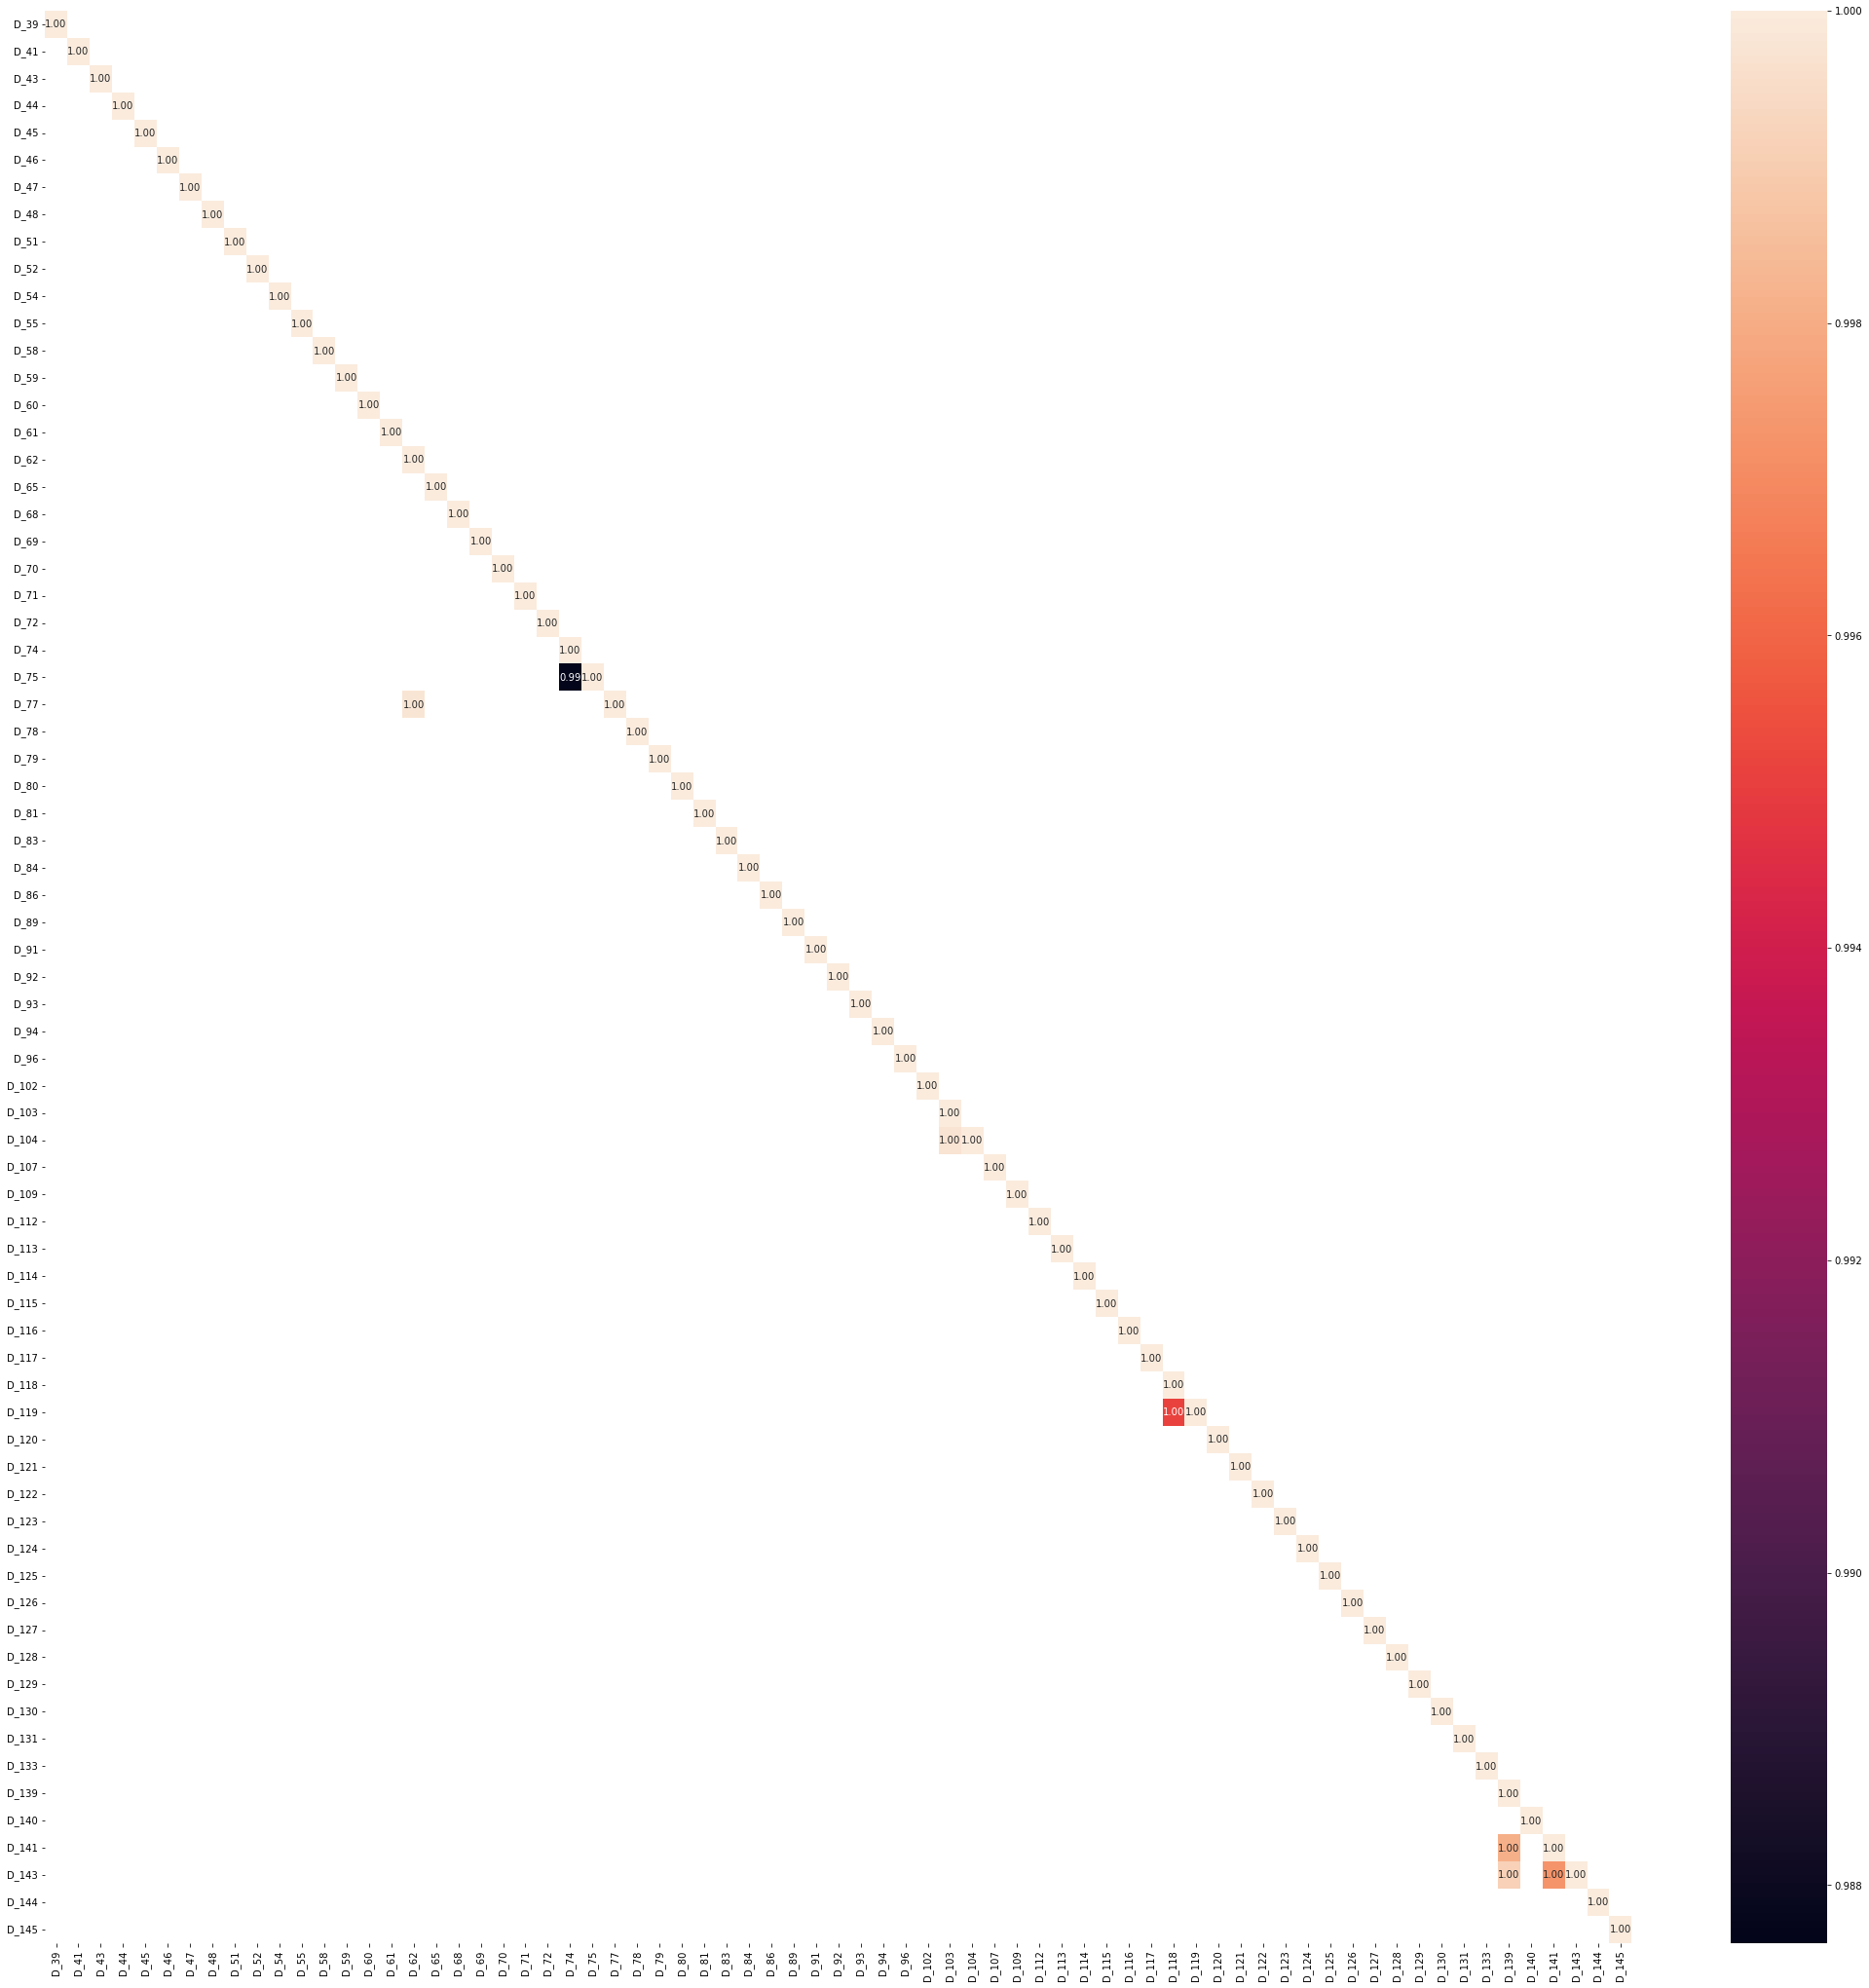

D_62 имеет корреляцию с D_77 = 0.9997772815125258
D_74 имеет корреляцию с D_75 = 0.9876281720376066
D_103 имеет корреляцию с D_104 = 0.9997423966605002
D_118 имеет корреляцию с D_119 = 0.9951490322524641
D_139 имеет корреляцию с D_141 = 0.9980717734545859
D_139 имеет корреляцию с D_143 = 0.999170607571504
D_141 имеет корреляцию с D_143 = 0.9972893964444669


,count,mean,std,min,25%,50%,75%,max
D_39,5531451.000000,0.151454,0.270596,0.000000,0.004528,0.009057,0.236641,5.389619
D_41,5529435.000000,0.058317,0.198434,0.000000,0.002873,0.005747,0.008616,8.988807
D_43,3873055.000000,0.154414,0.212911,0.000000,0.042275,0.088512,0.184321,10.111619
D_44,5257132.000000,0.115181,0.223764,0.000000,0.003833,0.007668,0.131948,5.634724
D_45,5529434.000000,0.250793,0.242217,0.000000,0.054629,0.180805,0.373322,1.610002
D_46,4319752.000000,0.477489,0.169118,-17.289343,0.425128,0.459670,0.517407,16.319901
D_47,5531451.000000,0.406809,0.234109,-0.026622,0.232351,0.383166,0.561549,1.643096
D_48,4812726.000000,0.380353,0.325986,-0.009615,0.081007,0.286172,0.669366,8.971425
D_51,5531451.000000,0.141228,0.242514,0.000000,0.003645,0.007283,0.336034,2.676606
D_52,5501888.000000,0.179868,0.173235,-0.007083,0.073875,0.144432,0.233146,1.010000


In [ ]:
eda_features(train_data, delinquency_features)

У большинcтва признаков максимальное значение равно 1, но

У некоторых признаков присутствуют экстремальные значения

От сильно коррелируемых признаком лучше избавиться.

Аналогично смотрим на другие признаки

### Spend_features

Признаки, характеризующие траты

,S_2,S_3,S_5,S_6,S_7,S_8,S_11,S_12,S_13,S_15,...,S_17,S_18,S_19,S_20,S_22,S_23,S_24,S_25,S_26,S_27
0,2017-03-09,0.124035,0.023381,0.008322,0.161345,0.922998,0.401619,0.272008,0.515222,0.108271,...,0.008033,0.005720,0.002537,0.009705,0.894090,0.135561,0.911191,0.974539,0.001243,0.676922
1,2017-04-07,0.126750,0.030599,0.002482,0.140951,0.919414,0.406326,0.188970,0.509048,0.101018,...,0.000760,0.007584,0.008427,0.009924,0.902135,0.136333,0.919876,0.975625,0.004561,0.822281
2,2017-05-28,0.123977,0.048367,0.000530,0.112229,1.001977,0.406768,0.495308,0.679257,0.103239,...,0.004056,0.005901,0.007327,0.008446,0.939654,0.134938,0.958699,0.974067,0.011736,0.853498
3,2017-06-13,0.117169,0.030063,0.000783,0.102838,0.704016,0.405175,0.508670,0.515282,0.206394,...,0.006969,0.002520,0.007053,0.006614,0.913205,0.140058,0.926341,0.975499,0.007571,0.844667
4,2017-07-16,0.117325,0.054221,0.006698,0.094311,0.917133,0.487460,0.216507,0.507712,0.106020,...,0.001770,0.000155,0.007728,0.005511,0.921026,0.131620,0.933479,0.978027,0.018200,0.811199


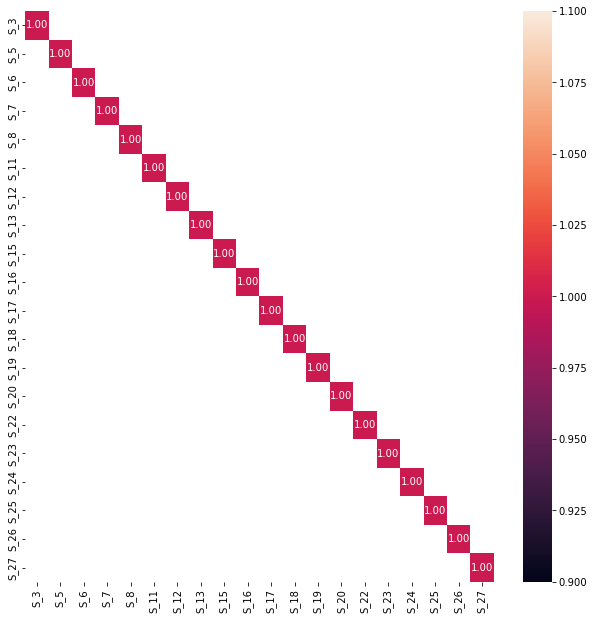

,count,mean,std,min,25%,50%,75%,max
S_3,4510907.000000,0.226468,0.192573,-0.627132,0.127259,0.163908,0.258102,5.482888
S_5,5531451.000000,0.086798,0.402543,0.000000,0.005636,0.013521,0.071321,206.875275
S_6,5531451.000000,0.239993,0.428939,0.000000,0.003285,0.006573,0.009859,1.010000
S_7,4510907.000000,0.223727,0.206007,-0.470132,0.093729,0.139701,0.295459,3.948271
S_8,5531451.000000,0.329115,0.302326,0.000000,0.007645,0.321748,0.494937,1.231413
S_11,5531451.000000,0.373581,0.190759,-0.199999,0.282444,0.289731,0.448762,3.801432
S_12,5531451.000000,0.242479,0.247339,-0.404109,0.186898,0.190826,0.208876,175.331421
S_13,5531451.000000,0.250471,0.297706,0.000000,0.004895,0.009797,0.427720,1.010000
S_15,5531451.000000,0.372088,0.194044,-0.300000,0.207550,0.401843,0.504834,5.308959
S_16,5531451.000000,0.049766,0.771202,0.000000,0.002553,0.005104,0.007657,231.758942


In [ ]:
eda_features(train_data, spend_features)

### Payment_features

Признаки, характеризующие платежи

,P_2,P_3,P_4
0,0.938469,0.736463,0.007554
1,0.936665,0.720886,0.004832
2,0.954180,0.738044,0.006561
3,0.960384,0.741813,0.009559
4,0.947248,0.691986,0.008156


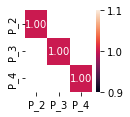

,count,mean,std,min,25%,50%,75%,max
P_2,5485466.000000,0.658189,0.244140,-0.458955,0.480331,0.694295,0.864816,1.010000
P_3,5229959.000000,0.601267,0.170024,-1.519690,0.540866,0.618303,0.683826,2.428051
P_4,5531451.000000,0.140370,0.339169,0.000000,0.002924,0.005849,0.008766,1.269390


In [ ]:
eda_features(train_data, payment_features)

### Balance_features

Признаки, характеризующие баланс

,B_1,B_2,B_3,B_4,B_5,B_6,B_7,B_8,B_9,B_10,...,B_28,B_30,B_31,B_32,B_33,B_36,B_37,B_38,B_40,B_41
0,0.008724,1.006838,0.004709,0.080986,0.170600,0.063902,0.059416,0.006466,0.008207,0.096219,...,0.084683,0.0,1,0.006626,1.001101,0.009968,0.004572,2.0,0.210060,0.006805
1,0.004923,1.000653,0.002714,0.069419,0.113239,0.065261,0.057744,0.001614,0.008373,0.099804,...,0.081843,0.0,1,0.001854,1.006779,0.003921,0.004654,2.0,0.184093,0.004407
2,0.021655,1.009672,0.009423,0.068839,0.060492,0.066982,0.056647,0.005126,0.009355,0.134073,...,0.081954,0.0,1,0.008686,1.001014,0.001264,0.019176,2.0,0.154837,0.003221
3,0.013683,1.002700,0.005531,0.055630,0.166782,0.083720,0.049253,0.001418,0.006782,0.134437,...,0.060634,0.0,1,0.002478,1.002775,0.002729,0.011720,2.0,0.153939,0.007703
4,0.015193,1.000727,0.009312,0.038862,0.143630,0.075900,0.048918,0.001199,0.000519,0.121518,...,0.062492,0.0,1,0.002199,1.006536,0.009998,0.017598,2.0,0.120717,0.009823


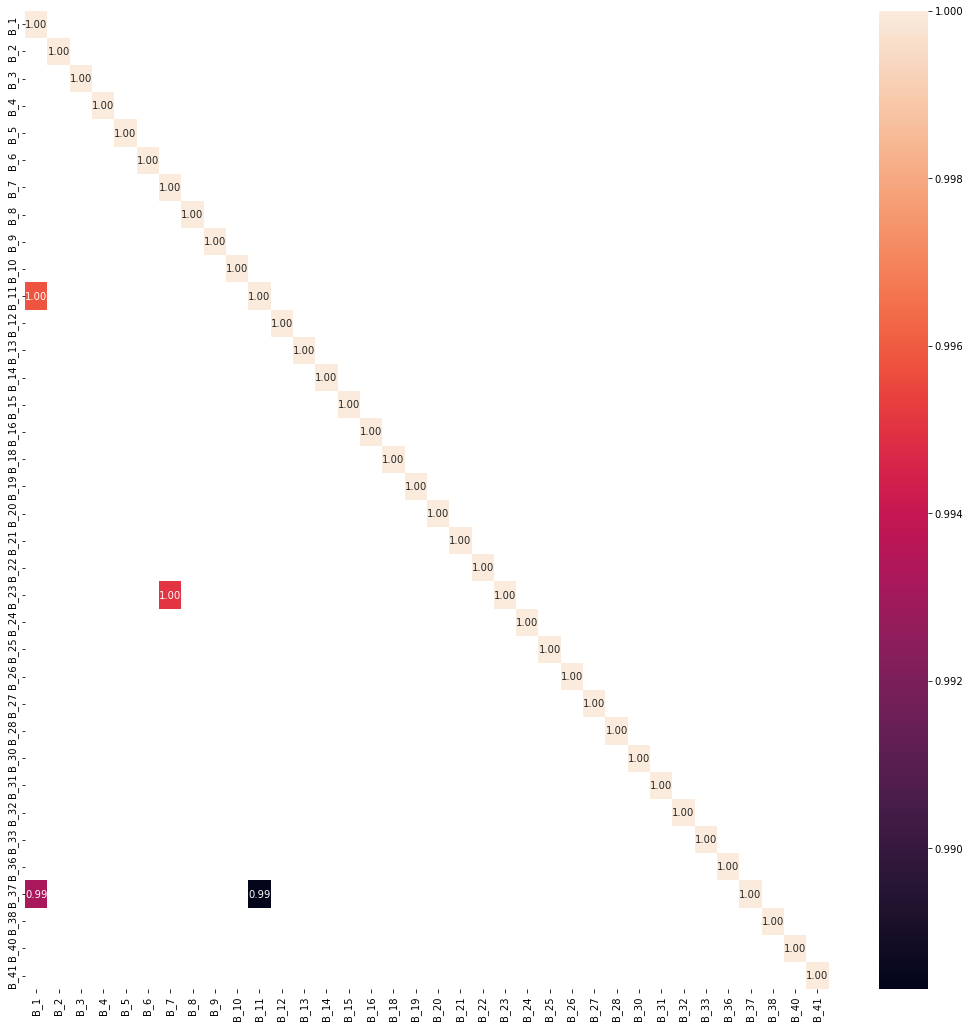

B_1 имеет корреляцию с B_11 = 0.9958433601804977
B_1 имеет корреляцию с B_37 = 0.9931933059250888
B_7 имеет корреляцию с B_23 = 0.9950655257607959
B_11 имеет корреляцию с B_37 = 0.9883147645085588


,count,mean,std,min,25%,50%,75%,max
B_1,5531451.000000,0.122600,0.213146,-7.588799,0.008864,0.031330,0.125902,1.324060
B_2,5529435.000000,0.610515,0.402919,0.000000,0.105331,0.814333,1.002403,1.010000
B_3,5529435.000000,0.130226,0.234398,0.000000,0.005228,0.009777,0.155051,1.625262
B_4,5531451.000000,0.171735,0.222453,0.000000,0.027500,0.082226,0.238882,19.803286
B_5,5531451.000000,0.081973,0.392920,0.000000,0.007280,0.015377,0.053718,144.207016
B_6,5531218.000000,0.150637,1.473210,-0.005178,0.020487,0.083385,0.191929,1214.516968
B_7,5531451.000000,0.184835,0.230800,-2.652749,0.028247,0.075746,0.270932,1.252750
B_8,5509183.000000,0.446101,0.501082,0.000000,0.004507,0.009021,1.004175,1.019079
B_9,5531451.000000,0.187152,0.285131,0.000000,0.005753,0.025878,0.334297,27.424858
B_10,5531451.000000,0.228768,4.796939,-0.002958,0.028991,0.110555,0.295539,4097.440918


In [ ]:
eda_features(train_data, balance_features)

### Risk_features

Признаки, характеризующие риск

,R_1,R_2,R_3,R_4,R_5,R_6,R_7,R_8,R_10,R_11,...,R_18,R_19,R_20,R_21,R_22,R_23,R_24,R_25,R_27,R_28
0,0.009228,0.006204,0.001423,0.008298,0.001882,0.008363,0.007562,0.001434,0.007121,0.002456,...,0.008907,0.005177,0.007782,0.002450,0.007479,0.006893,0.003950,0.003647,1.008949,0.001535
1,0.006151,0.006206,0.001984,0.005136,0.001610,0.004030,0.005304,0.000509,0.005966,0.000395,...,0.005907,0.008979,0.005987,0.002247,0.006827,0.002837,0.008351,0.008850,1.003205,0.004931
2,0.006815,0.003259,0.007426,0.006961,0.006328,0.006838,0.001422,0.008295,0.005447,0.007345,...,0.008882,0.002016,0.007291,0.007794,0.009820,0.005080,0.002471,0.009769,1.000754,0.009123
3,0.001373,0.009918,0.003515,0.008706,0.004980,0.008183,0.006363,0.005153,0.001888,0.004961,...,0.008348,0.003909,0.009977,0.007686,0.000458,0.007320,0.008507,0.004858,1.005338,0.002409
4,0.007605,0.006667,0.001362,0.003846,0.001653,0.008605,0.004831,0.007338,0.006111,0.002246,...,0.002678,0.003432,0.004105,0.009656,0.003341,0.000264,0.007190,0.002983,1.003175,0.004462


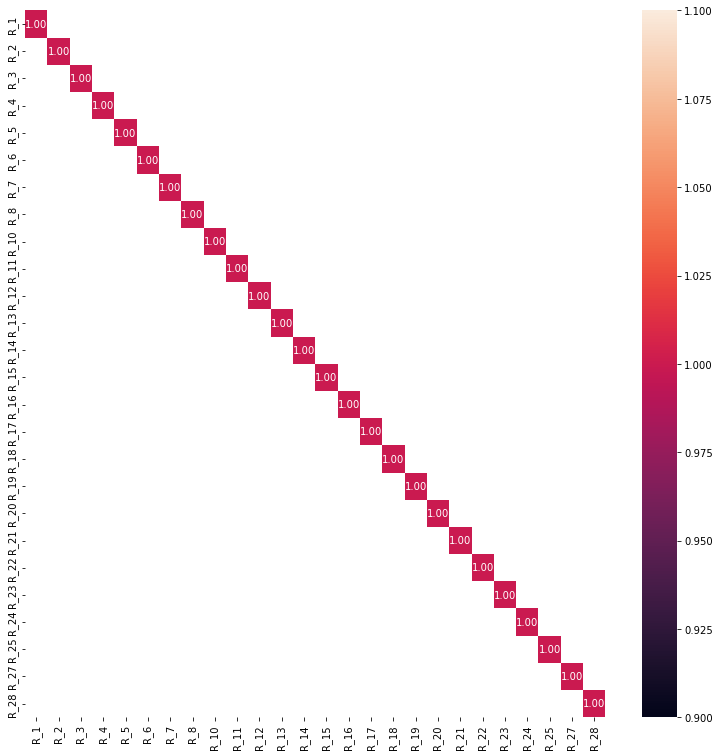

,count,mean,std,min,25%,50%,75%,max
R_1,5531451.000000,0.076328,0.222132,0.000000,0.002896,0.005782,0.008661,3.256284
R_2,5531451.000000,0.046648,0.198568,0.000000,0.002613,0.005223,0.007837,1.010000
R_3,5531451.000000,0.119100,0.211986,0.000000,0.004700,0.009401,0.200336,11.602601
R_4,5531451.000000,0.030706,0.157982,0.000000,0.002566,0.005133,0.007700,1.010000
R_5,5531451.000000,0.033988,0.255244,0.000000,0.002575,0.005149,0.007722,35.004517
R_6,5531451.000000,0.056955,0.639533,0.000000,0.002592,0.005187,0.007782,14.448201
R_7,5531450.000000,0.085382,1.548725,0.000000,0.002569,0.005136,0.007703,449.988892
R_8,5531451.000000,0.037426,0.302050,0.000000,0.002554,0.005106,0.007658,38.008080
R_10,5531451.000000,0.062823,0.301163,0.000000,0.002625,0.005247,0.007870,21.003672
R_11,5531451.000000,0.049743,0.172296,0.000000,0.002707,0.005414,0.008121,12.502596


In [ ]:
eda_features(train_data, risk_features)

In [ ]:
train_data.shape

(5531451, 151)

In [ ]:
train_data.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_129,B_41,D_130,D_131,D_133,R_28,D_139,D_140,D_144,D_145
0,-4532153018459703766,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,1.000080,0.006805,0.002052,0.005972,0.004345,0.001535,0.002427,0.003706,0.000610,0.002674
1,-4532153018459703766,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,1.008344,0.004407,0.001034,0.004838,0.007495,0.004931,0.003954,0.003167,0.005492,0.009217
2,-4532153018459703766,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,1.006878,0.003221,0.005681,0.005497,0.009227,0.009123,0.003269,0.007329,0.006986,0.002603
3,-4532153018459703766,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,...,1.007573,0.007703,0.007108,0.008261,0.007206,0.002409,0.006117,0.004516,0.006527,0.009600
4,-4532153018459703766,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,...,1.008132,0.009823,0.009680,0.004848,0.006312,0.004462,0.003671,0.004946,0.008126,0.009827


Заменим признак с датой на признак, отвечающий за количество дней, прошедший с первого до последнего обращения

In [ ]:
train_data.to_parquet('temp.parquet')

In [ ]:
train_data = pd.read_parquet('temp.parquet')

In [ ]:
train_data.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_129,B_41,D_130,D_131,D_133,R_28,D_139,D_140,D_144,D_145
0,-4532153018459703766,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,1.000080,0.006805,0.002052,0.005972,0.004345,0.001535,0.002427,0.003706,0.000610,0.002674
1,-4532153018459703766,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,1.008344,0.004407,0.001034,0.004838,0.007495,0.004931,0.003954,0.003167,0.005492,0.009217
2,-4532153018459703766,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,1.006878,0.003221,0.005681,0.005497,0.009227,0.009123,0.003269,0.007329,0.006986,0.002603
3,-4532153018459703766,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,...,1.007573,0.007703,0.007108,0.008261,0.007206,0.002409,0.006117,0.004516,0.006527,0.009600
4,-4532153018459703766,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,...,1.008132,0.009823,0.009680,0.004848,0.006312,0.004462,0.003671,0.004946,0.008126,0.009827


In [ ]:
last_day = train_data.groupby('customer_ID')['S_2'].max()

In [ ]:
first_day = train_data.groupby('customer_ID')['S_2'].min()
temp = last_day - first_day

In [ ]:
temp = temp.reset_index()

In [ ]:
temp.columns = ['customer_ID', 'S2_diff']

In [ ]:
train_data = train_data.merge(temp, on='customer_ID')

In [ ]:
train_data.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,B_41,D_130,D_131,D_133,R_28,D_139,D_140,D_144,D_145,S2_diff
0,-4532153018459703766,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,0.006805,0.002052,0.005972,0.004345,0.001535,0.002427,0.003706,0.000610,0.002674,369 days
1,-4532153018459703766,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,0.004407,0.001034,0.004838,0.007495,0.004931,0.003954,0.003167,0.005492,0.009217,369 days
2,-4532153018459703766,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,0.003221,0.005681,0.005497,0.009227,0.009123,0.003269,0.007329,0.006986,0.002603,369 days
3,-4532153018459703766,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,...,0.007703,0.007108,0.008261,0.007206,0.002409,0.006117,0.004516,0.006527,0.009600,369 days
4,-4532153018459703766,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,...,0.009823,0.009680,0.004848,0.006312,0.004462,0.003671,0.004946,0.008126,0.009827,369 days


In [ ]:
train_data.drop(columns=['S_2'], inplace=True)

In [ ]:
train_data['S_2'] = train_data.S2_diff.dt.days

In [ ]:
train_data.drop(columns=['S2_diff'], inplace=True)

[Text(0, 0, '2018-03-01'),
 Text(1, 0, '2018-03-02'),
 Text(2, 0, '2018-03-03'),
 Text(3, 0, '2018-03-04'),
 Text(4, 0, '2018-03-05'),
 Text(5, 0, '2018-03-06'),
 Text(6, 0, '2018-03-07'),
 Text(7, 0, '2018-03-08'),
 Text(8, 0, '2018-03-09'),
 Text(9, 0, '2018-03-10'),
 Text(10, 0, '2018-03-11'),
 Text(11, 0, '2018-03-12'),
 Text(12, 0, '2018-03-13'),
 Text(13, 0, '2018-03-14'),
 Text(14, 0, '2018-03-15'),
 Text(15, 0, '2018-03-16'),
 Text(16, 0, '2018-03-17'),
 Text(17, 0, '2018-03-18'),
 Text(18, 0, '2018-03-19'),
 Text(19, 0, '2018-03-20'),
 Text(20, 0, '2018-03-21'),
 Text(21, 0, '2018-03-22'),
 Text(22, 0, '2018-03-23'),
 Text(23, 0, '2018-03-24'),
 Text(24, 0, '2018-03-25'),
 Text(25, 0, '2018-03-26'),
 Text(26, 0, '2018-03-27'),
 Text(27, 0, '2018-03-28'),
 Text(28, 0, '2018-03-29'),
 Text(29, 0, '2018-03-30'),
 Text(30, 0, '2018-03-31')]

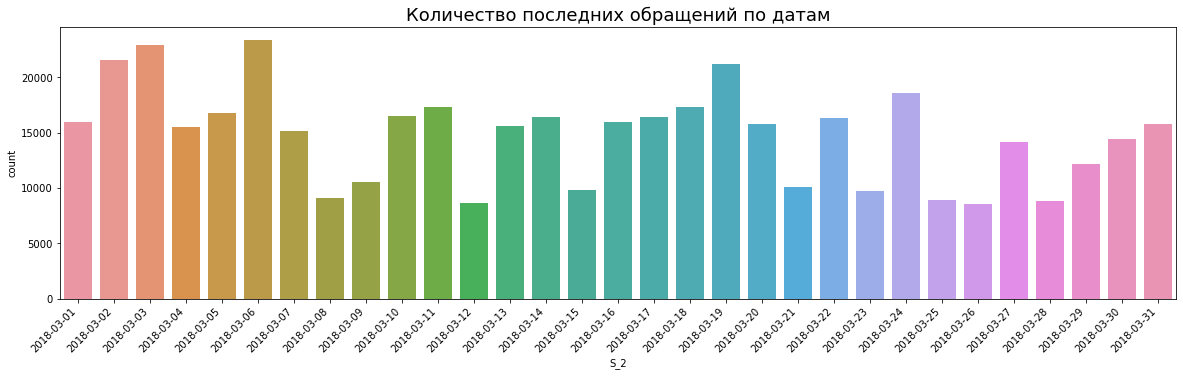

In [ ]:
fig = plt.figure(figsize=(20, 5))

ax = plt.axes()
ax.set_title('Количество последних обращений по датам', fontsize=18)

sns.countplot(data=last_day.reset_index(), x=last_day.reset_index()['S_2'])

dates = last_day.reset_index()['S_2'].dt.strftime(
    '%Y-%m-%d').sort_values().unique()
ax.set_xticklabels(labels=dates, rotation=45, ha='right')

### Target

Посмотрим на данные с таргетом

In [ ]:
train_labels = pd.read_parquet('train_labels.parquet')

Text(0.5, 1.0, 'Target')

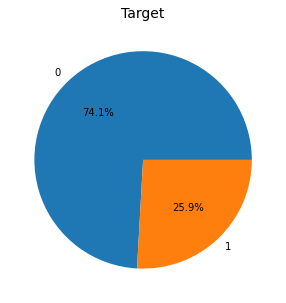

In [ ]:
target = train_labels.target.value_counts(normalize=True).mul(100)
fig = plt.figure(figsize=(5, 5))
plt.pie(target, autopct="%.1f%%", labels=target.index)
plt.title("Target", fontsize=14)

Как и предпологалось, таргет несбалансирован

In [ ]:
train_data_merged = train_data.merge(train_labels, on='customer_ID')

In [ ]:
train_data_merged.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,B_41,D_130,D_131,D_133,R_28,D_139,D_140,D_144,D_145,target
0,-4532153018459703766,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,0.006805,0.002052,0.005972,0.004345,0.001535,0.002427,0.003706,0.000610,0.002674,0
1,-4532153018459703766,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,0.004407,0.001034,0.004838,0.007495,0.004931,0.003954,0.003167,0.005492,0.009217,0
2,-4532153018459703766,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,0.003221,0.005681,0.005497,0.009227,0.009123,0.003269,0.007329,0.006986,0.002603,0
3,-4532153018459703766,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,...,0.007703,0.007108,0.008261,0.007206,0.002409,0.006117,0.004516,0.006527,0.009600,0
4,-4532153018459703766,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,...,0.009823,0.009680,0.004848,0.006312,0.004462,0.003671,0.004946,0.008126,0.009827,0


In [ ]:
del train_data
gc.collect()

9975

In [ ]:
def eda_target_features(features: list) -> None:
    """
    Исследование признаков, наиболее коррелирующих с таргетом > 0.3.
    Их распределение относительно таргета.
    :param features: - группа признаков
    return: None
    """
    corr = train_data_merged.loc[:300000, features +
                                 ['target']].corr(method='pearson')[['target']]
    eps = 0.3
    if len(features) < 5:
        eps = 1
    plt.figure(figsize=(1, len(features)*eps))
    sns.heatmap(corr, annot=True, fmt='.2f', mask=(np.abs(corr) <= 0.3))

    cor_with_t = []
    cor_with_t = [index for index in corr.index if corr.loc[index][0] >= 0.3]
    cor_with_t.remove('target')
    if not cor_with_t:
        cor_with_t = cor_with_t + features
    print(f'Коррелирует с таргетом {cor_with_t}')
    if len(cor_with_t) == 1:
        fig = plt.figure()
        sns.kdeplot(
            data=train_data_merged[:100000], common_norm=False, x=cor_with_t[0], hue='target')
    else:
        fig = plt.figure(figsize=(20, 5*round(len(cor_with_t)/2)))
        nrows = round(len(cor_with_t)/2)
        ncols = 2
        for l in range(len(cor_with_t)):
            ax = fig.add_subplot(nrows, ncols, l+1)
            sns.kdeplot(
                data=train_data_merged[:100000], common_norm=False, x=cor_with_t[l], hue='target', ax=ax)
    del corr
    gc.collect()

Коррелирует с таргетом ['D_44', 'D_48', 'D_55', 'D_58', 'D_61', 'D_74']


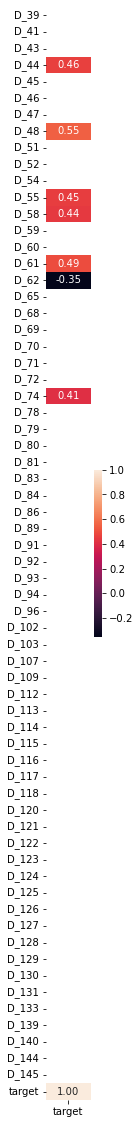

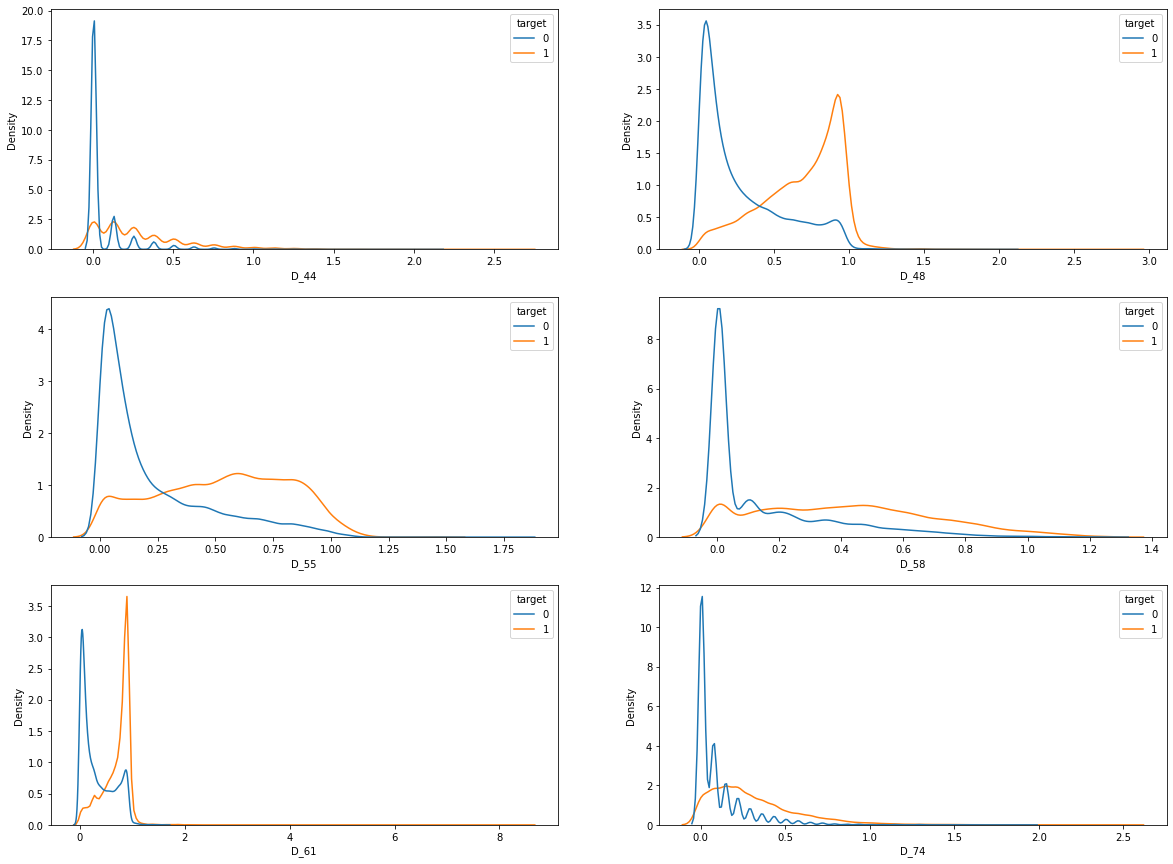

In [ ]:
eda_target_features(delinquency_features)

Коррелирует с таргетом ['S_3', 'S_7']


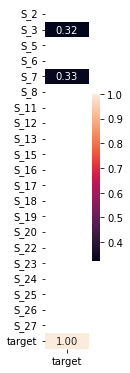

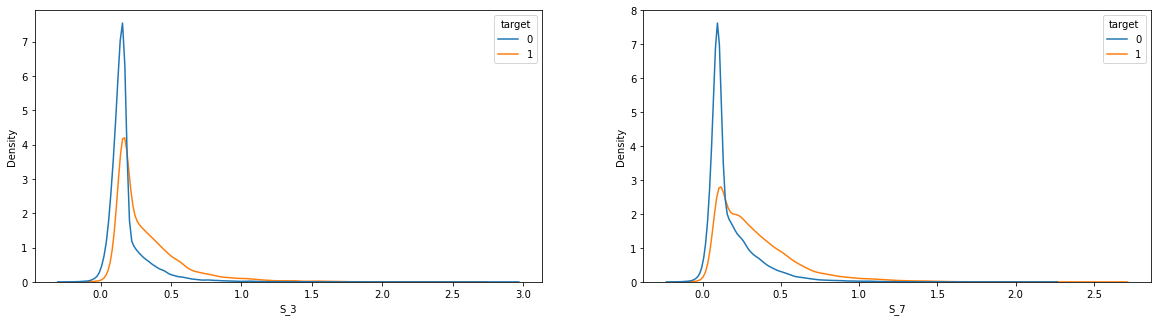

In [ ]:
eda_target_features(spend_features)

Коррелирует с таргетом ['P_2', 'P_3', 'P_4']


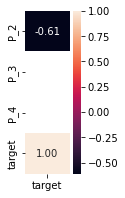

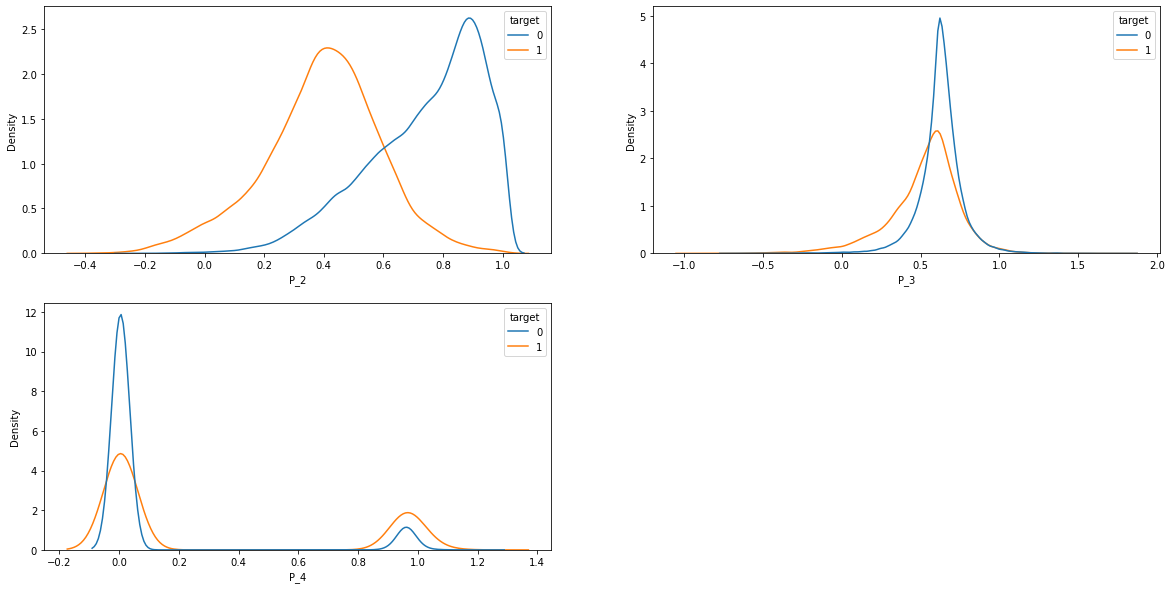

In [ ]:
eda_target_features(payment_features)

Коррелирует с таргетом ['B_1', 'B_3', 'B_4', 'B_7', 'B_8', 'B_9', 'B_16', 'B_19', 'B_20', 'B_22', 'B_30', 'B_38']


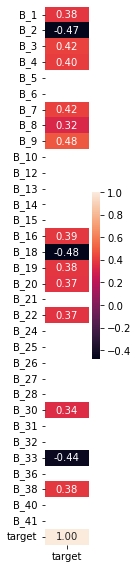

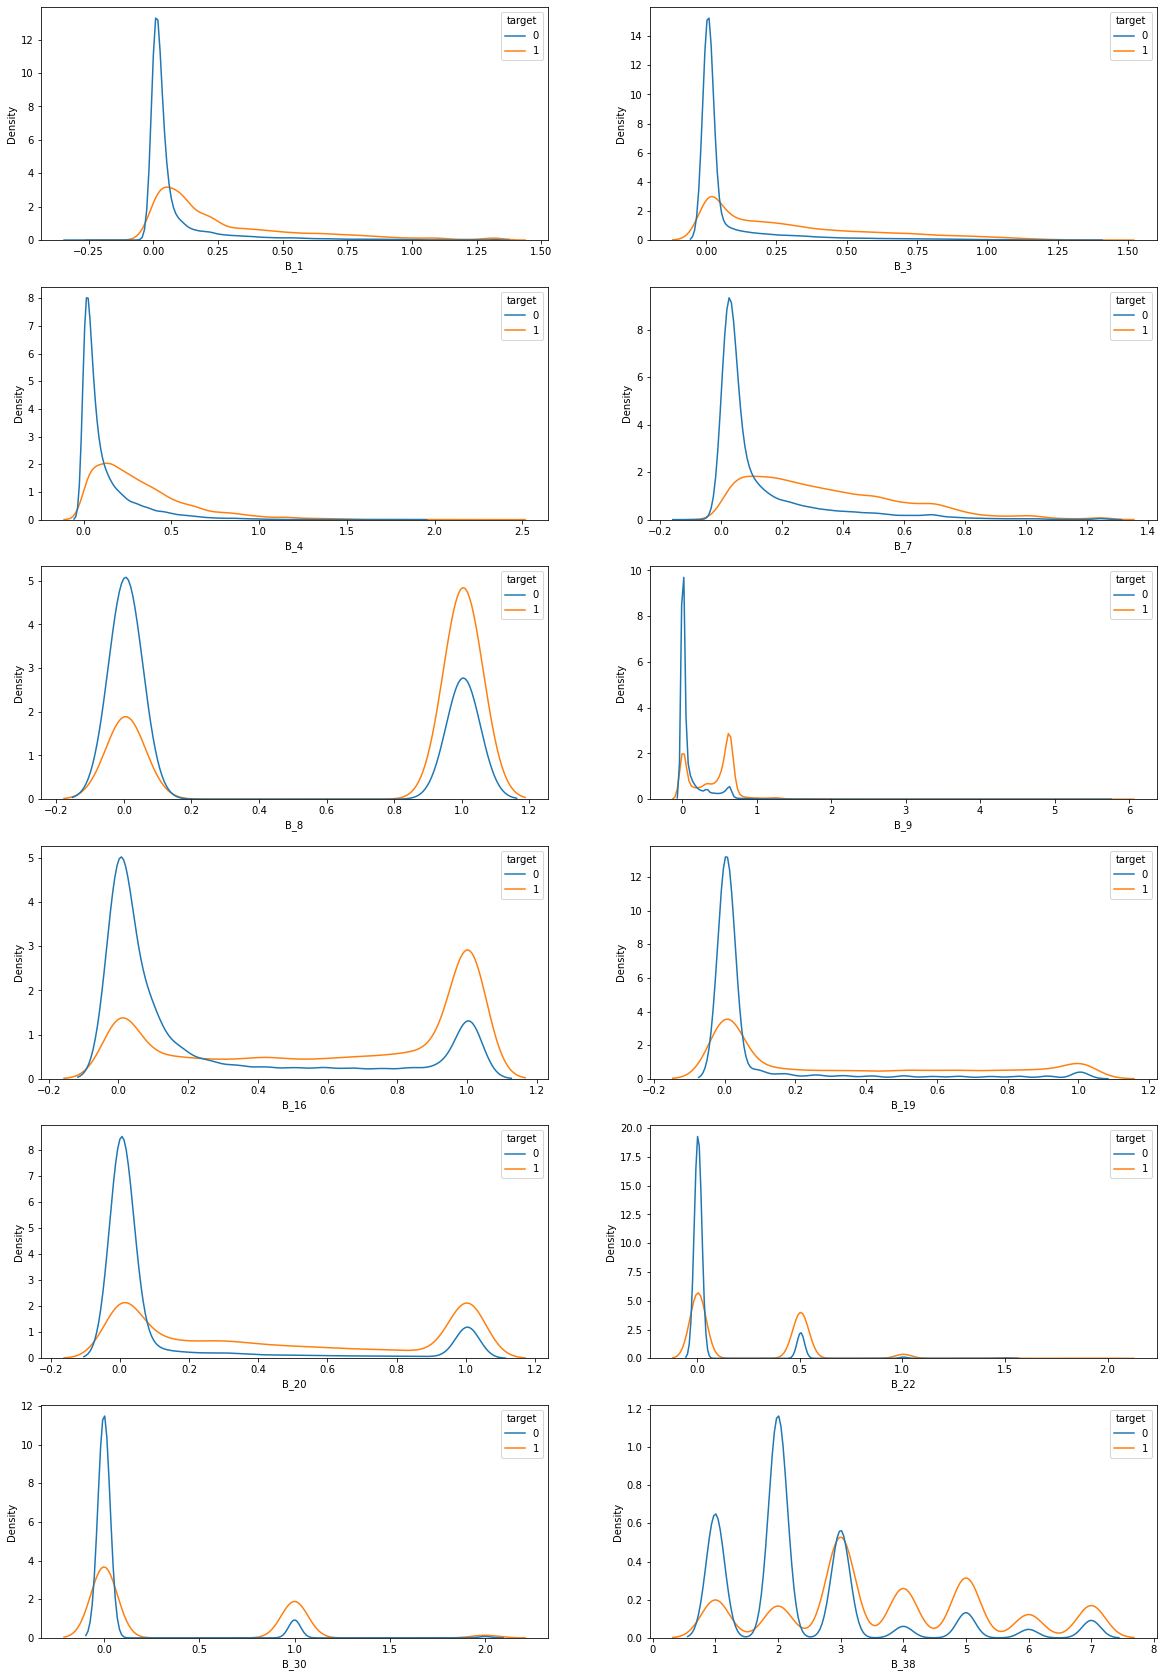

In [ ]:
eda_target_features(balance_features)

Коррелирует с таргетом ['R_1']


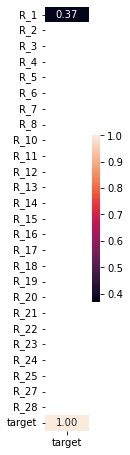

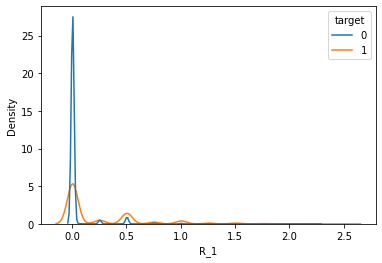

In [ ]:
eda_target_features(risk_features)

In [ ]:
train_data_merged.to_parquet('train_data_merged.parquet')

In [ ]:
train_data_merged = pd.read_parquet('train_data_merged.parquet')

## PREPROCESSING

Заполним пропуски

In [ ]:
train_data_merged.fillna(method="ffill", inplace=True)
train_data_merged.fillna(method="bfill", inplace=True)

In [ ]:
train_data_merged.head()

,customer_ID,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,...,D_130,D_131,D_133,R_28,D_139,D_140,D_144,D_145,S_2,target
0,-4532153018459703766,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,0.5256,...,0.002052,0.005972,0.004345,0.001535,0.002427,0.003706,0.000610,0.002674,369,0
1,-4532153018459703766,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,0.5256,...,0.001034,0.004838,0.007495,0.004931,0.003954,0.003167,0.005492,0.009217,369,0
2,-4532153018459703766,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,0.5256,...,0.005681,0.005497,0.009227,0.009123,0.003269,0.007329,0.006986,0.002603,369,0
3,-4532153018459703766,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,0.5256,...,0.007108,0.008261,0.007206,0.002409,0.006117,0.004516,0.006527,0.009600,369,0
4,-4532153018459703766,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,0.5256,...,0.009680,0.004848,0.006312,0.004462,0.003671,0.004946,0.008126,0.009827,369,0


In [ ]:
train_data_merged[train_data_merged['customer_ID'] == 8873414224926116961]

,customer_ID,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,...,D_130,D_131,D_133,R_28,D_139,D_140,D_144,D_145,S_2,target
2467576,8873414224926116961,0.371593,0.91968,0.522882,0.004126,0.000964,0.172333,0.452067,0.347654,0.017833,...,1.004068,0.978857,0.264021,0.008469,1.009237,0.006244,0.002297,0.097473,0,1


In [ ]:
def get_difference(data: pd.DataFrame, num_features: list) ->: pd.DataFrame:
    """
    Находим разницы в значение признака между месяцами
    params:
    - data: pd.DataFrame - набор данных
    - num_features: list - признаки, для которых нужно найти разницу
    return: pd.DataFrame
    """
    df1 = []
    customer_ids = []
    for customer_id, df in data.groupby(['customer_ID']):
        diff_df1 = df[num_features].diff(
            1).iloc[[-1]].values.astype(np.float32)
        df1.append(diff_df1)
        customer_ids.append(customer_id)
    df1 = np.concatenate(df1, axis=0)
    df1 = pd.DataFrame(
        df1, columns=[col + '_diff1' for col in df[num_features].columns])
    df1['customer_ID'] = customer_ids
    del diff_df1
    gc.collect()
    return df1

Сгруппируем данные по клиентам, получим новые признаки, характеризующие среднее, минимальное, максимальное значение признака для каждого клиента. А также образуем новые признаки, найдя разницs между значениями каждого месяца

In [ ]:
def agg_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Аггрегируем данные. Для числовых находим среднее, мин, макс и разницу между первым и последним элементом
    Для категориальных: количество, последний элемент и количество уникальных значений
    params:
    - df: pd.DataFrame - набор данных
    return: pd.DataFrame
    """
    cols = list(df.columns)
    cat_feat = ["B_30", "B_38", "D_114", "D_116",
                "D_117", "D_120", "D_126", "D_63", "D_64", "D_68"]
    for col in cat_feat + ['customer_ID', 'S_2', 'target']:
        cols.remove(col)
    num_feat = cols

    num_agg = df.groupby("customer_ID")[num_feat].agg(
        ['mean', 'first', 'min', 'max', 'last'])
    num_agg.columns = ['_'.join(x) for x in num_agg.columns]

    for col in num_feat:
        num_agg[col+'_diff'] = num_agg[col + '_last'] - num_agg[col+'_first']
        num_agg.drop(
            columns=[col+'_first'], inplace=True)
    num_agg.reset_index(inplace=True)

    df_diff = get_difference(df, num_feat)

    cat_agg = df.groupby("customer_ID")[cat_feat].agg(
        ['count', 'last', 'nunique'])
    cat_agg.columns = ['_'.join(x) for x in cat_agg.columns]
    cat_agg.reset_index(inplace=True)

    df = num_agg.merge(cat_agg, how='inner', on='customer_ID').merge(
        df_diff, how='inner', on='customer_ID')

    print('shape', df.shape)
    del num_agg, cat_agg, df_diff
    gc.collect()
    return df

In [ ]:
train_data_grouped = agg_data(train_data_merged)

shape (458913, 865)


In [ ]:
train_data_grouped.set_index('customer_ID', inplace=True)

In [ ]:
train_data_grouped['S_2'] = train_data_merged[['customer_ID', 'S_2']].groupby(
    'customer_ID').tail(1).set_index('customer_ID')
train_data_grouped['target'] = train_data_merged[['customer_ID', 'target']].groupby(
    'customer_ID').tail(1).set_index('customer_ID')

In [ ]:
train_data_grouped.head()

,P_2_mean,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_min,D_39_max,D_39_last,B_1_mean,B_1_min,...,D_130_diff1,D_131_diff1,D_133_diff1,R_28_diff1,D_139_diff1,D_140_diff1,D_144_diff1,D_145_diff1,S2,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
-9223358381327749917,0.415868,0.340178,0.498727,0.387708,0.081480,0.004225,0.475809,0.008372,0.431062,0.298571,...,-0.008051,-0.002392,0.005208,-0.000090,-0.000446,0.007722,0.006017,-0.000515,346,1
-9223193039457028513,0.974068,0.964483,1.002478,1.001372,0.006276,0.000665,0.008913,0.006031,0.004292,0.001238,...,0.007843,0.000101,0.004557,0.000936,-0.006619,-0.002226,-0.001580,-0.002194,358,0
-9223189665817919541,0.802447,0.694073,0.828761,0.694073,0.005912,0.000736,0.009972,0.004324,0.006611,0.001909,...,-0.006700,0.001541,0.003302,-0.000963,-0.996916,0.000490,-1.331635,-0.091838,364,0
-9223188534444851899,0.791203,0.786647,0.794826,0.787945,0.004678,0.000449,0.009318,0.006101,0.004780,0.000845,...,0.004784,-0.000144,0.002666,0.001780,-0.001235,0.003990,-0.002107,0.004087,365,0
-9223173911659837606,0.115666,0.038207,0.252421,0.040486,0.135075,0.002394,0.506699,0.388033,0.111619,0.105406,...,-0.000733,0.002829,0.000159,0.008291,-0.004252,-0.005298,0.000790,0.002966,346,1


In [ ]:
del temp
del first_day
del last_day
del train_data_merged
gc.collect()

926

Категориальные признаки, которые уже бинаризованы, переведём в тип int, а оставшиеся бинаризуем

In [ ]:
cat_feat = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117',
            'D_120', 'D_126', 'D_63', 'D_64', 'D_68']

In [ ]:
cat_feat = [x + '_last' for x in cat_feat]

In [ ]:
train_data_grouped[list(set(cat_feat)-{'D_63_last', 'D_64_last'})] = \
    train_data_grouped[list(
        set(cat_feat)-{'D_63_last', 'D_64_last'})].astype(int)

In [ ]:
train_bin = train_data_grouped.copy()
le = LabelEncoder()

for f in ['D_63_last', 'D_64_last']:
    train_bin[f] = le.fit_transform(train_bin[f])

train_bin.head()

,P_2_mean,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_min,D_39_max,D_39_last,B_1_mean,B_1_min,...,D_130_diff1,D_131_diff1,D_133_diff1,R_28_diff1,D_139_diff1,D_140_diff1,D_144_diff1,D_145_diff1,S2,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
-9223358381327749917,0.415868,0.340178,0.498727,0.387708,0.081480,0.004225,0.475809,0.008372,0.431062,0.298571,...,-0.008051,-0.002392,0.005208,-0.000090,-0.000446,0.007722,0.006017,-0.000515,346,1
-9223193039457028513,0.974068,0.964483,1.002478,1.001372,0.006276,0.000665,0.008913,0.006031,0.004292,0.001238,...,0.007843,0.000101,0.004557,0.000936,-0.006619,-0.002226,-0.001580,-0.002194,358,0
-9223189665817919541,0.802447,0.694073,0.828761,0.694073,0.005912,0.000736,0.009972,0.004324,0.006611,0.001909,...,-0.006700,0.001541,0.003302,-0.000963,-0.996916,0.000490,-1.331635,-0.091838,364,0
-9223188534444851899,0.791203,0.786647,0.794826,0.787945,0.004678,0.000449,0.009318,0.006101,0.004780,0.000845,...,0.004784,-0.000144,0.002666,0.001780,-0.001235,0.003990,-0.002107,0.004087,365,0
-9223173911659837606,0.115666,0.038207,0.252421,0.040486,0.135075,0.002394,0.506699,0.388033,0.111619,0.105406,...,-0.000733,0.002829,0.000159,0.008291,-0.004252,-0.005298,0.000790,0.002966,346,1


In [ ]:
train_data_grouped = train_data_grouped.reset_index()

In [ ]:
train_bin = train_bin.reset_index()

In [ ]:
train_data_grouped = pd.read_parquet('train_data_grouped_1.parquet')

In [ ]:
train_bin = pd.read_parquet('train_bin_1.parquet')

Произведем рекурсивный отбор признаков

In [ ]:
X = train_data_grouped.drop(columns=['customer_ID', 'target'])
y = train_data_grouped['target']

In [ ]:
selector = BoostRFE(LGBMClassifier(), min_features_to_select=100, step=5)

In [ ]:
selector.fit(X, y, verbose=3)

BoostRFE(estimator=LGBMClassifier(), min_features_to_select=100, step=5)

In [ ]:
train_data_grouped = train_data_grouped.loc[:, [
    'customer_ID'] + list(selector.transform(X).columns) + ['target']]
train_bin = train_bin.loc[:, ['customer_ID'] +
                          list(selector.transform(X).columns) + ['target']]

In [ ]:
train_data_grouped.set_index('customer_ID', inplace=True)
train_bin.set_index('customer_ID', inplace=True)

In [ ]:
train_bin.to_parquet('train_bin_3.parquet')
train_data_grouped.to_parquet('train_data_grouped_3.parquet')